## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import urllib.request
from sklearn.preprocessing import LabelEncoder, StandardScaler
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE
import pandas as pd




## Datos

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df_train = pd.read_csv("./data/train.csv", index_col = 0)
df_train.index.name = None
df_train

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00
...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,800.00
1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,1629.00
78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,519.00
23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,258.00


## Exploración de los datos

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [4]:
import pandas as pd
import re

# Copia del dataframe original para transformaciones
df_train_processed = df_train.copy()

# 1) Mantener Company sin transformar (CatBoost maneja categóricas)

# 2) Transformar Product (primera palabra o última si es alfanumérico)
def extract_product_keyword(product):
    words = product.split()
    if words[-1].isalnum() and any(c.isalpha() for c in words[-1]) and any(c.isdigit() for c in words[-1]):
        return words[-1]  # Si es alfanumérico, tomar la última palabra
    return words[0]  # En otro caso, tomar la primera palabra

df_train_processed["Product"] = df_train_processed["Product"].apply(extract_product_keyword)

# 3) Mantener TypeName sin transformar

# 4) Transformar ScreenResolution tomando solo el último código alfanumérico
def extract_screen_res(resolution):
    matches = re.findall(r'\d+x\d+', resolution)
    return matches[-1] if matches else "Unknown"

df_train_processed["ScreenResolution"] = df_train_processed["ScreenResolution"].apply(extract_screen_res)

# 5) Dividir CPU en tres columnas
def extract_cpu_parts(cpu):
    parts = cpu.split()
    first_word = parts[0] if len(parts) > 0 else "Unknown"
    third_word = parts[2] if len(parts) > 2 else "Unknown"
    last_word = parts[-1] if len(parts) > 0 else "Unknown"
    return first_word, third_word, last_word

df_train_processed[["CPU_Brand", "CPU_Model", "CPU_Speed"]] = df_train_processed["Cpu"].apply(lambda x: pd.Series(extract_cpu_parts(x)))

# Transformar CPU_Model en una variable numérica con sentido
def categorize_cpu(cpu):
    if "i7" in cpu:
        return 3
    elif "i5" in cpu:
        return 2
    elif "i3" in cpu:
        return 1
    else:
        return 0

df_train_processed["CPU_Model_number"] = df_train_processed["CPU_Model"].apply(categorize_cpu)

# 6) Dividir Memory en dos columnas
def extract_memory_parts(memory):
    parts = memory.split()
    first_word = parts[0] if len(parts) > 0 else "Unknown"
    last_word = parts[-1] if len(parts) > 1 else "Unknown"
    return first_word, last_word

df_train_processed[["Memory_Capacity", "Memory_Type"]] = df_train_processed["Memory"].apply(lambda x: pd.Series(extract_memory_parts(x)))

# 7) Dividir Gpu en tres columnas
def extract_gpu_parts(gpu):
    parts = gpu.split()
    first_word = parts[0] if len(parts) > 0 else "Unknown"
    second_word = parts[1] if len(parts) > 1 else "Unknown"
    last_word = parts[-1] if len(parts) > 2 else "Unknown"
    return first_word, second_word, last_word

df_train_processed[["GPU_Brand", "GPU_Type", "GPU_Model"]] = df_train_processed["Gpu"].apply(lambda x: pd.Series(extract_gpu_parts(x)))

# 8) Reducir OpSys a seis categorías
def categorize_os(os):
    os = os.lower()
    if "windows" in os:
        return "Windows"
    elif "linux" in os:
        return "Linux"
    elif "mac" in os or "macos" in os:
        return "Mac"
    elif "android" in os:
        return "Android"
    elif "chrome" in os or "chromebook" in os:
        return "Chrome"
    else:
        return "Others"

df_train_processed["OpSys_type"] = df_train_processed["OpSys"].apply(categorize_os)
# Extraer el número del sistema operativo si existe
df_train_processed["OpSys_number"] = df_train_processed["OpSys"].str.extract(r'(\d+)')

# Convertir a número (NaN se llenará con 0 o algún otro valor si es necesario)
df_train_processed["OpSys_number"] = df_train_processed["OpSys_number"].fillna(0).astype(int)

# Limpiar y convertir columnas numéricas

# 1) Convertir Ram a numérico (eliminando "GB")
df_train_processed["Ram"] = df_train_processed["Ram"].str.replace("GB", "", regex=True).astype(int)

# 2) Convertir Weight a numérico (eliminando "kg")
df_train_processed["Weight"] = df_train_processed["Weight"].str.replace("kg", "", regex=True).astype(float)

# 3) Crear nuevas características
# Calcular el número total de píxeles
df_train_processed["Pixel_Count"] = df_train_processed["ScreenResolution"].apply(lambda x: int(x.split('x')[0]) * int(x.split('x')[1]) if 'x' in x else 0)

# Densidad de píxeles por pulgada (DPI)
df_train_processed["DPI"] = df_train_processed["Pixel_Count"] / (df_train_processed["Inches"] ** 2)

# Relación entre peso y tamaño de pantalla
df_train_processed["Weight_per_Inch"] = df_train_processed["Weight"] / df_train_processed["Inches"]

# Relación CPU y RAM
df_train_processed["CPU_Ratio"] = df_train_processed["CPU_Brand"].astype(str) + "_" + df_train_processed["Ram"].astype(str)

# Mantener las columnas categóricas como strings para CatBoost
df_train_processed["Company"] = df_train_processed["Company"].astype(str)
df_train_processed["Product"] = df_train_processed["Product"].astype(str)
df_train_processed["TypeName"] = df_train_processed["TypeName"].astype(str)
df_train_processed["ScreenResolution"] = df_train_processed["ScreenResolution"].astype(str)
df_train_processed["CPU_Brand"] = df_train_processed["CPU_Brand"].astype(str)
df_train_processed["CPU_Model"] = df_train_processed["CPU_Model"].astype(str)
df_train_processed["CPU_Speed"] = df_train_processed["CPU_Speed"].str[:-3].astype(float)
df_train_processed["Memory_Capacity"] = df_train_processed["Memory_Capacity"].str.replace('TB', '000').str.replace('GB', '').astype(float)
df_train_processed["Memory_Type"] = df_train_processed["Memory_Type"].astype(str)
df_train_processed["GPU_Brand"] = df_train_processed["GPU_Brand"].astype(str)
df_train_processed["GPU_Model"] = df_train_processed["GPU_Model"].astype(str)
df_train_processed["OpSys"] = df_train_processed["OpSys"].astype(str)

# Eliminar columnas originales que ya fueron transformadas
df_train_processed.drop(columns=["OpSys", "Cpu", "Memory", "Gpu"], inplace=True)

# Renombrar el dataset final
df_train_processed = df_train_processed

df_train_processed



,Company,Product,TypeName,Inches,ScreenResolution,Ram,Weight,Price_in_euros,CPU_Brand,CPU_Model,...,Memory_Type,GPU_Brand,GPU_Type,GPU_Model,OpSys_type,OpSys_number,Pixel_Count,DPI,Weight_per_Inch,CPU_Ratio
755,HP,G6,Notebook,15.6,1920x1080,8,1.86,539.00,Intel,i3,...,SSD,Intel,HD,520,Windows,10,2073600,8520.710059,0.119231,Intel_8
618,Dell,Inspiron,Gaming,15.6,1920x1080,16,2.59,879.01,Intel,i7,...,HDD,Nvidia,GeForce,960<U+039C>,Windows,10,2073600,8520.710059,0.166026,Intel_16
909,HP,ProBook,Notebook,15.6,1920x1080,8,2.04,900.00,Intel,i7,...,HDD,Nvidia,GeForce,930MX,Windows,10,2073600,8520.710059,0.130769,Intel_8
2,Apple,Macbook,Ultrabook,13.3,1440x900,8,1.34,898.94,Intel,i5,...,Storage,Intel,HD,6000,Mac,0,1296000,7326.587145,0.100752,Intel_8
286,Dell,Inspiron,Notebook,15.6,1920x1080,4,2.25,428.00,Intel,i3,...,HDD,AMD,Radeon,M430,Linux,0,2073600,8520.710059,0.144231,Intel_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron,Notebook,15.6,1920x1080,8,2.20,800.00,Intel,i5,...,SSD,AMD,Radeon,530,Windows,10,2073600,8520.710059,0.141026,Intel_8
1160,HP,Spectre,2 in 1 Convertible,13.3,1920x1080,8,1.48,1629.00,Intel,i5,...,SSD,Intel,HD,520,Windows,10,2073600,11722.539431,0.111278,Intel_8
78,Lenovo,IdeaPad,Notebook,15.6,1920x1080,8,2.20,519.00,Intel,i5,...,HDD,Intel,HD,620,Others,0,2073600,8520.710059,0.141026,Intel_8
23,HP,G6,Notebook,15.6,1366x768,4,1.86,258.00,AMD,E2-9000e,...,HDD,AMD,Radeon,R2,Others,0,1049088,4310.848126,0.119231,AMD_4


In [5]:
df_train_processed['CPU_Model'].value_counts()

CPU_Model
i7           374
i5           282
i3            93
Dual          68
Quad          26
M             15
9420           7
9220           6
x5-Z8350       5
9720P          5
A10-9620P      2
A6-9220        2
7410           2
E2-9000e       2
9410           2
x5-Z8550       2
A9-9420        2
1700           2
7110           1
E2-9000        1
Z8350          1
E3-1535M       1
1600           1
9620P          1
x5-Z8300       1
9600P          1
9830P          1
E2-6110        1
9000e          1
6110           1
E3-1505M       1
X5-Z8350       1
7310           1
Name: count, dtype: int64

In [6]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Ram               912 non-null    int32  
 6   Weight            912 non-null    float64
 7   Price_in_euros    912 non-null    float64
 8   CPU_Brand         912 non-null    object 
 9   CPU_Model         912 non-null    object 
 10  CPU_Speed         912 non-null    float64
 11  CPU_Model_number  912 non-null    int64  
 12  Memory_Capacity   912 non-null    float64
 13  Memory_Type       912 non-null    object 
 14  GPU_Brand         912 non-null    object 
 15  GPU_Type          912 non-null    object 
 16  GPU_Model         912 non-null    object 
 17  

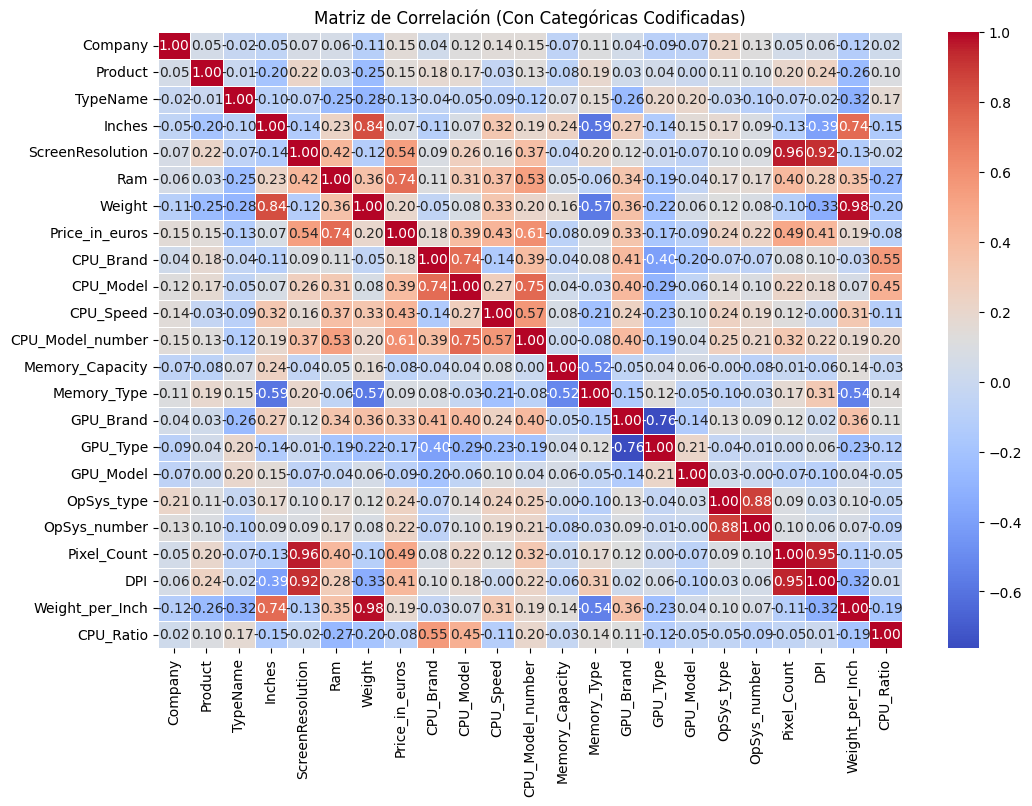

In [7]:
# Hacer una copia del dataset
df_encoded = df_train_processed.copy()

# Aplicar Label Encoding a todas las columnas categóricas
for col in df_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Calcular la matriz de correlación con las variables categóricas transformadas
corr_matrix = df_encoded.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Con Categóricas Codificadas)")
plt.show()

In [8]:
# Definir un umbral de correlación mínima
correlation_threshold = 0.07

# Seleccionar variables con alta correlación con Price_in_euros
correlated_features = corr_matrix["Price_in_euros"].abs()
relevant_features = correlated_features[correlated_features > correlation_threshold].index.tolist()

# Filtrar el dataset con las variables más relevantes
df_train_filtered = df_encoded[relevant_features]

In [9]:
df_train_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    int32  
 1   Product           912 non-null    int32  
 2   TypeName          912 non-null    int32  
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    int32  
 5   Ram               912 non-null    int32  
 6   Weight            912 non-null    float64
 7   Price_in_euros    912 non-null    float64
 8   CPU_Brand         912 non-null    int32  
 9   CPU_Model         912 non-null    int32  
 10  CPU_Speed         912 non-null    float64
 11  CPU_Model_number  912 non-null    int64  
 12  Memory_Capacity   912 non-null    float64
 13  Memory_Type       912 non-null    int32  
 14  GPU_Brand         912 non-null    int32  
 15  GPU_Type          912 non-null    int32  
 16  GPU_Model         912 non-null    int32  
 17  

-----------------------------------------------------------------------------------------------------------------

In [10]:
df_test = pd.read_csv("./data/test.csv", index_col=0)
df_test.index.name = None
df_test

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg
...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg


 ## 2. Replicar el procesado para ``test.csv``

In [11]:
import pandas as pd
import re

# Copia del dataframe original para transformaciones
df_test_processed = df_test.copy()

# 1) Mantener Company sin transformar (CatBoost maneja categóricas)

# 2) Transformar Product (primera palabra o última si es alfanumérico)
def extract_product_keyword(product):
    words = product.split()
    if words[-1].isalnum() and any(c.isalpha() for c in words[-1]) and any(c.isdigit() for c in words[-1]):
        return words[-1]  # Si es alfanumérico, tomar la última palabra
    return words[0]  # En otro caso, tomar la primera palabra

df_test_processed["Product"] = df_test_processed["Product"].apply(extract_product_keyword)

# 3) Mantener TypeName sin transformar

# 4) Transformar ScreenResolution tomando solo el último código alfanumérico
def extract_screen_res(resolution):
    matches = re.findall(r'\d+x\d+', resolution)
    return matches[-1] if matches else "Unknown"

df_test_processed["ScreenResolution"] = df_test_processed["ScreenResolution"].apply(extract_screen_res)

# 5) Dividir CPU en tres columnas
def extract_cpu_parts(cpu):
    parts = cpu.split()
    first_word = parts[0] if len(parts) > 0 else "Unknown"
    third_word = parts[2] if len(parts) > 2 else "Unknown"
    last_word = parts[-1] if len(parts) > 0 else "Unknown"
    return first_word, third_word, last_word

df_test_processed[["CPU_Brand", "CPU_Model", "CPU_Speed"]] = df_test_processed["Cpu"].apply(lambda x: pd.Series(extract_cpu_parts(x)))

# Transformar CPU_Model en una variable numérica con sentido
def categorize_cpu(cpu):
    if "i7" in cpu:
        return 3
    elif "i5" in cpu:
        return 2
    elif "i3" in cpu:
        return 1
    else:
        return 0

df_test_processed["CPU_Model_number"] = df_test_processed["CPU_Model"].apply(categorize_cpu)

# 6) Dividir Memory en dos columnas
def extract_memory_parts(memory):
    parts = memory.split()
    first_word = parts[0] if len(parts) > 0 else "Unknown"
    last_word = parts[-1] if len(parts) > 1 else "Unknown"
    return first_word, last_word

df_test_processed[["Memory_Capacity", "Memory_Type"]] = df_test_processed["Memory"].apply(lambda x: pd.Series(extract_memory_parts(x)))

# 7) Dividir Gpu en tres columnas
def extract_gpu_parts(gpu):
    parts = gpu.split()
    first_word = parts[0] if len(parts) > 0 else "Unknown"
    second_word = parts[1] if len(parts) > 1 else "Unknown"
    last_word = parts[-1] if len(parts) > 2 else "Unknown"
    return first_word, second_word, last_word

df_test_processed[["GPU_Brand", "GPU_Type", "GPU_Model"]] = df_test_processed["Gpu"].apply(lambda x: pd.Series(extract_gpu_parts(x)))

# 8) Reducir OpSys a seis categorías
def categorize_os(os):
    os = os.lower()
    if "windows" in os:
        return "Windows"
    elif "linux" in os:
        return "Linux"
    elif "mac" in os or "macos" in os:
        return "Mac"
    elif "android" in os:
        return "Android"
    elif "chrome" in os or "chromebook" in os:
        return "Chrome"
    else:
        return "Others"

df_test_processed["OpSys_type"] = df_test_processed["OpSys"].apply(categorize_os)
# Extraer el número del sistema operativo si existe
df_test_processed["OpSys_number"] = df_test_processed["OpSys"].str.extract(r'(\d+)')

# Convertir a número (NaN se llenará con 0 o algún otro valor si es necesario)
df_test_processed["OpSys_number"] = df_test_processed["OpSys_number"].fillna(0).astype(int)

# Limpiar y convertir columnas numéricas

# 1) Convertir Ram a numérico (eliminando "GB")
df_test_processed["Ram"] = df_test_processed["Ram"].str.replace("GB", "", regex=True).astype(int)

# 2) Convertir Weight a numérico (eliminando "kg")
df_test_processed["Weight"] = df_test_processed["Weight"].str.replace("kg", "", regex=True).astype(float)

# 3) Crear nuevas características
# Calcular el número total de píxeles
df_test_processed["Pixel_Count"] = df_test_processed["ScreenResolution"].apply(lambda x: int(x.split('x')[0]) * int(x.split('x')[1]) if 'x' in x else 0)

# Densidad de píxeles por pulgada (DPI)
df_test_processed["DPI"] = df_test_processed["Pixel_Count"] / (df_test_processed["Inches"] ** 2)

# Relación entre peso y tamaño de pantalla
df_test_processed["Weight_per_Inch"] = df_test_processed["Weight"] / df_test_processed["Inches"]

# Relación CPU y RAM
df_test_processed["CPU_Ratio"] = df_test_processed["CPU_Brand"].astype(str) + "_" + df_test_processed["Ram"].astype(str)

# Mantener las columnas categóricas como strings para CatBoost
df_test_processed["Company"] = df_test_processed["Company"].astype(str)
df_test_processed["Product"] = df_test_processed["Product"].astype(str)
df_test_processed["TypeName"] = df_test_processed["TypeName"].astype(str)
df_test_processed["ScreenResolution"] = df_test_processed["ScreenResolution"].astype(str)
df_test_processed["CPU_Brand"] = df_test_processed["CPU_Brand"].astype(str)
df_test_processed["CPU_Model"] = df_test_processed["CPU_Model"].astype(str)
df_test_processed["CPU_Speed"] = df_test_processed["CPU_Speed"].str[:-3].astype(float)
df_test_processed["Memory_Capacity"] = df_test_processed["Memory_Capacity"].str.replace('TB', '000').str.replace('GB', '').astype(float)
df_test_processed["Memory_Type"] = df_test_processed["Memory_Type"].astype(str)
df_test_processed["GPU_Brand"] = df_test_processed["GPU_Brand"].astype(str)
df_test_processed["GPU_Model"] = df_test_processed["GPU_Model"].astype(str)
df_test_processed["OpSys"] = df_test_processed["OpSys"].astype(str)

# Eliminar columnas originales que ya fueron transformadas
df_test_processed.drop(columns=["OpSys", "Cpu", "Memory", "Gpu"], inplace=True)

# Renombrar el dataset final
df_test_processed = df_test_processed

df_test_processed

,Company,Product,TypeName,Inches,ScreenResolution,Ram,Weight,CPU_Brand,CPU_Model,CPU_Speed,...,Memory_Type,GPU_Brand,GPU_Type,GPU_Model,OpSys_type,OpSys_number,Pixel_Count,DPI,Weight_per_Inch,CPU_Ratio
209,Lenovo,Legion,Gaming,15.6,1920x1080,16,2.400,Intel,i7,2.8,...,SSD,Nvidia,GeForce,1060,Others,0,2073600,8520.710059,0.153846,Intel_16
1281,Acer,Aspire,Notebook,15.6,1366x768,4,2.400,Intel,Dual,1.6,...,HDD,Intel,HD,400,Linux,0,1049088,4310.848126,0.153846,Intel_4
1168,Lenovo,V110-15ISK,Notebook,15.6,1366x768,4,1.900,Intel,i3,2.0,...,HDD,Intel,HD,520,Others,0,1049088,4310.848126,0.121795,Intel_4
1231,Dell,Inspiron,2 in 1 Convertible,15.6,1920x1080,8,2.191,Intel,i5,2.5,...,SSD,Intel,HD,620,Windows,10,2073600,8520.710059,0.140449,Intel_8
1020,HP,ProBook,Notebook,14.0,1920x1080,4,1.950,Intel,i5,2.5,...,SSD,Intel,HD,620,Windows,10,2073600,10579.591837,0.139286,Intel_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,MSI,7RG,Gaming,17.3,1920x1080,16,2.900,Intel,i7,2.8,...,HDD,Nvidia,GeForce,1070,Windows,10,2073600,6928.397207,0.167630,Intel_16
948,Toshiba,Tecra,Notebook,14.0,1920x1080,4,1.470,Intel,i5,2.3,...,SSD,Intel,HD,520,Windows,10,2073600,10579.591837,0.105000,Intel_4
483,Dell,M5520,Workstation,15.6,1920x1080,8,1.780,Intel,i7,2.8,...,SSD,Nvidia,Quadro,M1200,Windows,10,2073600,8520.710059,0.114103,Intel_8
1017,HP,Probook,Notebook,14.0,1366x768,4,1.640,Intel,i5,2.5,...,HDD,Intel,HD,620,Windows,10,1049088,5352.489796,0.117143,Intel_4


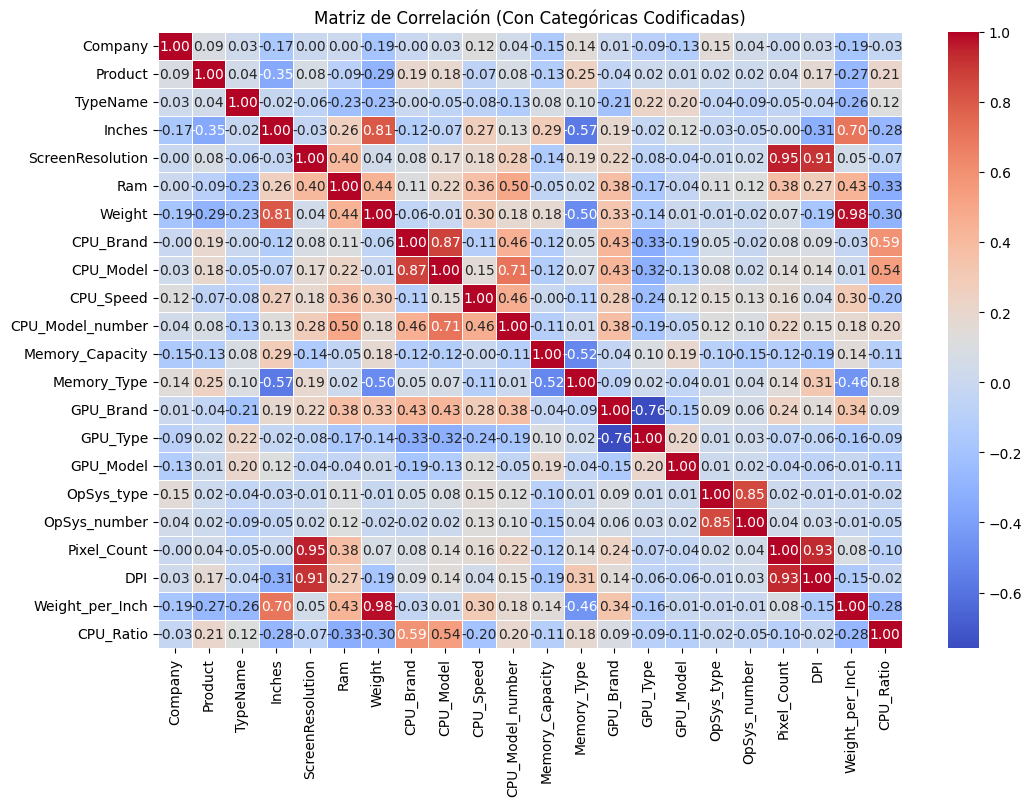

In [12]:
# Hacer una copia del dataset de test
df_test_encoded = df_test_processed.copy()

# Aplicar Label Encoding usando los mismos encoders de train
for col in df_test_encoded.select_dtypes(include=["object"]).columns:
    if col in df_train_processed.columns:  # Asegurar que la columna existe en train
        le = LabelEncoder()
        le.fit(df_train_processed[col])  # Usar las categorías aprendidas en train
        df_test_encoded[col] = df_test_encoded[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# Calcular la matriz de correlación con las variables categóricas transformadas
corr_matrix = df_test_encoded.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Con Categóricas Codificadas)")
plt.show()

In [13]:
# Filtrar test con las mismas columnas seleccionadas en train
selected_features = df_train_filtered.drop(columns=["Price_in_euros"]).columns  # Excluir la variable objetivo

# Asegurar que el test solo tenga las columnas seleccionadas en train
df_test_filtered = df_test_encoded[selected_features]

In [14]:
df_test_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           391 non-null    int32  
 1   Product           391 non-null    int64  
 2   TypeName          391 non-null    int32  
 3   Inches            391 non-null    float64
 4   ScreenResolution  391 non-null    int64  
 5   Ram               391 non-null    int32  
 6   Weight            391 non-null    float64
 7   CPU_Brand         391 non-null    int64  
 8   CPU_Model         391 non-null    int64  
 9   CPU_Speed         391 non-null    float64
 10  CPU_Model_number  391 non-null    int64  
 11  Memory_Capacity   391 non-null    float64
 12  Memory_Type       391 non-null    int32  
 13  GPU_Brand         391 non-null    int64  
 14  GPU_Type          391 non-null    int64  
 15  GPU_Model         391 non-null    int64  
 16  OpSys_type        391 non-null    int32  
 17  

In [15]:
# Relación entre RAM y CPU
df_train_filtered["Ram_per_CPU"] = df_train_filtered["Ram"] / (df_train_filtered["CPU_Speed"] + 0.1)
df_test_filtered["Ram_per_CPU"] = df_test_filtered["Ram"] / (df_test_filtered["CPU_Speed"] + 0.1)

# Tamaño de pantalla en relación con píxeles
df_train_filtered["Pixel_Density"] = df_train_filtered["Pixel_Count"] / (df_train_filtered["Inches"] ** 2)
df_test_filtered["Pixel_Density"] = df_test_filtered["Pixel_Count"] / (df_test_filtered["Inches"] ** 2)

# Eficiencia del almacenamiento (peso vs capacidad)
df_train_filtered["Storage_Efficiency"] = df_train_filtered["Memory_Capacity"] / (df_train_filtered["Weight"] + 0.1)
df_test_filtered["Storage_Efficiency"] = df_test_filtered["Memory_Capacity"] / (df_test_filtered["Weight"] + 0.1)


## Modelado

In [ ]:

# Seleccionar solo columnas numéricas excluyendo "Price_in_euros"
numerical_cols = df_train_processed.select_dtypes(include=["number"]).columns.tolist()
numerical_cols.remove("Price_in_euros")  # Excluir la variable objetivo

# Aplicar normalización con StandardScaler
scaler = StandardScaler()
df_train_processed[numerical_cols] = scaler.fit_transform(df_train_processed[numerical_cols])
df_test_processed[numerical_cols] = scaler.transform(df_test_processed[numerical_cols])  # Usar los mismos parámetros de train

print("Datos numéricos normalizados correctamente.")

# Separar variables predictoras y objetivo
X = df_train_filtered.drop(columns=["Price_in_euros"])  # Excluir variable objetivo
y = df_train_filtered["Price_in_euros"]

# Aplicar Eliminación Recursiva de Características (RFE) con LightGBM
base_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
rfe = RFE(estimator=base_model, n_features_to_select=10, step=1)
rfe.fit(X, y)

# Seleccionar las mejores características
selected_features = X.columns[rfe.support_]
print("Mejores características seleccionadas:", selected_features)

# Filtrar el dataset con las mejores características
X = X[selected_features]
df_test_filtered = df_test_filtered[selected_features]

# Dividir en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar columnas categóricas (CatBoost maneja estas columnas directamente)
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Modelos a probar
models = {
    "Linear Regression": LinearRegression(),
    "CatBoost": CatBoostRegressor(loss_function="RMSE", verbose=0, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Optimización de hiperparámetros
param_grids = {
    "CatBoost": {"depth": [6, 8, 10], "learning_rate": [0.01, 0.05, 0.1], "iterations": [500, 1000, 1500]},
    "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 5, 7]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]},
    "LightGBM": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 5, 7]}
}

best_models = {}

for name, model in models.items():
    if name in param_grids:  # Optimización solo para modelos con hiperparámetros
        search = RandomizedSearchCV(model, param_grids[name], n_iter=15, cv=3, scoring="neg_root_mean_squared_error", verbose=1, n_jobs=-1)
        search.fit(X_train, y_train)
        best_models[name] = search.best_estimator_
        print(f"{name} mejores hiperparámetros: {search.best_params_}")
    else:  # Para regresión lineal, entrenar directamente
        model.fit(X_train, y_train)
        best_models[name] = model

# Evaluar modelos optimizados
for name, model in best_models.items():
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"{name} RMSE: {rmse}")

# Seleccionar el mejor modelo basado en RMSE
best_model_name = min(best_models, key=lambda k: np.sqrt(mean_squared_error(y_val, best_models[k].predict(X_val))))
best_model = best_models[best_model_name]
print(f"Mejor modelo seleccionado: {best_model_name}")

# Generar predicciones para Kaggle
y_test_pred = best_model.predict(df_test_filtered)

# Guardar las predicciones en un archivo CSV para Kaggle
df_submission = pd.DataFrame({"laptop_ID": df_test.index, "Price_in_euros": y_test_pred})
df_submission.to_csv("submission_best_model.csv", index=False)

print(f"Predicciones guardadas en 'submission_best_model.csv' usando {best_model_name}.")


Datos numéricos normalizados correctamente.
Fitting 3 folds for each of 15 candidates, totalling 45 fits
CatBoost mejores hiperparámetros: {'learning_rate': 0.1, 'iterations': 1000, 'depth': 6}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
XGBoost mejores hiperparámetros: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Random Forest mejores hiperparámetros: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 20}
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 729, number of used features: 25
[LightGBM] [Info] Start training from score 1103.789314
[LightGBM] [Warning] No

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

------------------------------------------------------------

## Optimizacion

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [17]:
sample = pd.read_csv("./data/sample_submission.csv")
sample

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6
...,...,...
386,820,474.3
387,948,1468.8
388,483,520.4
389,1017,515.1


### 4. Mete tus predicciones en un dataframe llamado ``submission``.

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [18]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")